# Distributional Repair Algorithm

The distributional repair algorithm is adapted from the work of Abigail Longbridge et al.
https://arxiv.org/pdf/2403.13864

This algorithm learns an optimal transport plan from the privileged and unprivileged groups to the barycentre between them. This plan can then be applied to either the training data or the test data to repair the dataset under the notion of conditional independence.

In [1]:
# Load all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity

from aif360.datasets import AdultDataset

from humancompatible.repair.distributional_repair import DistributionalRepair

This demo file uses the adult dataset to demonstrate the distributional repair algorithm.

In [2]:
def load_adult_dataset(s,u,x,y):
    def custom_preprocessing(df):
        pd.set_option('future.no_silent_downcasting', True)
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)
        # 1 if education-num is greater than 9, 0 otherwise
        df['college_educated'] = (df['education-num'] > 9).astype(int)

        #drop nan columns
        df = df.dropna()

        return df

    adult = AdultDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

KL divergence is used as the distance metric between the original and repaired data distributions. Is calculated for each feature, with the the average KL divergence across all features used as the final distance metric, U-Mean KLD.

In [3]:
def _eval_kld(x_0, x_1):
    support = np.linspace(np.min([np.min(x_0), np.min(x_1)]), np.max([np.max(x_0), np.max(x_1)]), 500).reshape(-1,1)
    kde_0 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_0.reshape(-1,1))
    pmf_0 = np.exp(kde_0.score_samples(support)) 
    #add a small value to avoid division by zero
    pmf_0 += 1e-10
    kde_1 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_1.reshape(-1,1))
    pmf_1 = np.exp(kde_1.score_samples(support))
    pmf_1 += 1e-10
    return - np.sum(pmf_0 * np.log(pmf_1 / pmf_0))

def eval_kld(x, s, u, order=[0,1]):
    tot_kld = 0.0
    for u_val, u_count in u.value_counts().items():
        mask_0 = np.asarray((u == u_val) & (s == 0))
        mask_1 = np.asarray((u == u_val) & (s == 1))
        if (np.sum(mask_0) == 0) or (np.sum(mask_1) == 0):
            continue
        tmp = _eval_kld(x[mask_0].values, x[mask_1].values)
        if np.isnan(tmp):
            continue
        tot_kld += tmp * u_count / len(u)
    return tot_kld

## Parameters for Distributional Repair Algorithm

- `n_q` is the number of support points for the probability distribution function. This defaults to 250, however this can be increased to improve the accuracy of the repair algorithm.
  
- `S` is the protected or sensitive attribute for which the repair is against

- `U` the name of the unprotected attribute. This should not be a sensitive attribute, or be used later by a model to predict the outcome.

- `X` is a list of features used by the model to make its predictions. This should not include the sensitive attribute.

- `X_continuous` is a list of continuous features in `X`

- `Y` is the outcome of a model, which is predicted using the features in `X`. This should be a binary outcome.

In [4]:
n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated pdfs

S = 'sex'
U = 'college_educated'
X = ['age','hours-per-week']
X_continuous= ['age','hours-per-week']
Y = 'Income Binary'

## Step 1: Split the data into a research and archive set

The research dataset will be used by the repair algorithm to generate an optimal transport plan that can be used to drive data towards the barycentre of the distributions of the protected and unprotected groups. The archive dataset will be used to evaluate the performance of the repair algorithm.

In [5]:
data = load_adult_dataset(S,U,X,Y)
dataset_R, dataset_A = data.split([n_R], shuffle=True)

## Step 2: Initialise the repair algorithm

The Distributional Repair Algorithm is initialised with the research dataset, and the parameters:
- `S`
  
- `U`
  
- `X`
  
- `Y`
  
- `X_continuous`
  
- `n_q` *(optional)*

In [6]:

dist_repair = DistributionalRepair(S,U,X,Y,X_continuous,n_q)


## Step 3: Fit the repair algorithm
Using the research dataset as the input, the fit method derives an optimal transport plan used to repair the data under the notion of conditional independence.

In [7]:
dist_repair.fit(dataset_R)

## Step  4: Transform the data

The transform method is used to repair the data in the archive dataset by applying the optimal transport plan. The method returns the repaired data, and can be used to repair either the research or archive dataset.

In [8]:

dataset_A_repaired = dist_repair.transform(dataset_A)
dataset_R_repaired = dist_repair.transform(dataset_R)

## Evaluating the repair algorithm
The U-Mean KLD value can be calculated for both the repaired and the original data. The U-Mean KLD value is the average KL divergence across all features, and is used to evaluate the performance of the repair algorithm. The lower the U-Mean KLD value, the better the repair algorithm has performed.

In [9]:
tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][X]
tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][X]
kld_x_R = np.zeros(shape=(len(X), 2))
kld_x_tilde_R = np.zeros(shape=(len(X), 2))
kld_x_A = np.zeros(shape=(len(X), 2))
kld_x_tilde_A = np.zeros(shape=(len(X), 2))
pos = np.arange(len(X))
for i, feat in enumerate(X):
    kld_x_R[i, 0] = eval_kld(dist_repair.x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[0, 1])
    kld_x_R[i, 1] = eval_kld(dist_repair.x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[1, 0])
    kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[0, 1])
    kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[1, 0])
    kld_x_A[i, 0] = eval_kld(dataset_A.convert_to_dataframe()[0][X][feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[0, 1])
    kld_x_A[i, 1] = eval_kld(dataset_A.convert_to_dataframe()[0][X][feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[1, 0])
    kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[0, 1])
    kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], dataset_A.convert_to_dataframe()[0][S], dataset_A.convert_to_dataframe()[0][U], order=[1, 0])
kld_x_A_mean = np.mean(kld_x_A, axis=1)
kld_x_tilde_A_mean = np.mean(kld_x_tilde_A, axis=1)
kld_x_R_mean = np.mean(kld_x_R, axis=1)
kld_x_tilde_R_mean = np.mean(kld_x_tilde_R, axis=1)

## Plotting the results

The plot below demonstrates how the repair algorithm has performed. Successful repair is indicated by the repaired scores (green) being lower than the original scores (red).

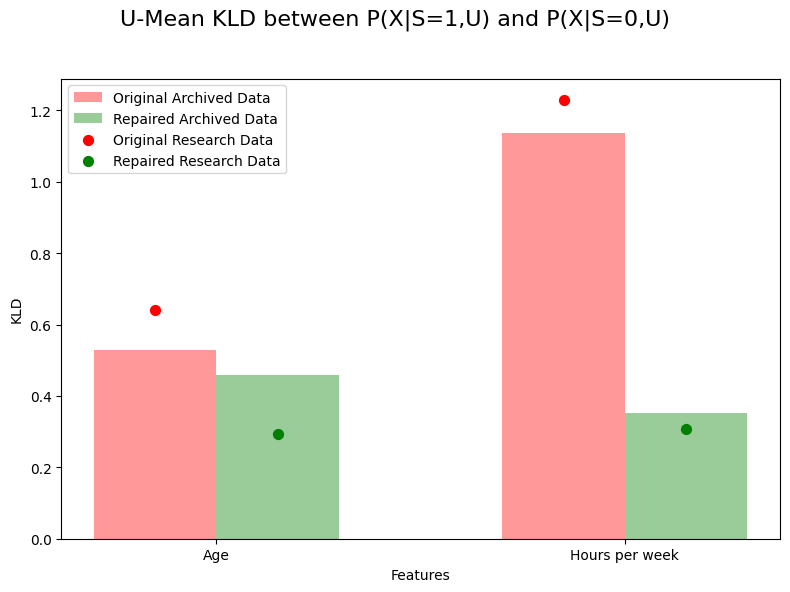

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.3
original_color = 'red'
repaired_color = 'green'

original_bars = ax.bar(x=pos - bar_width/2, height=kld_x_A_mean, width=bar_width, alpha=0.4, color=original_color)
repaired_bars = ax.bar(x=pos + bar_width/2, height=kld_x_tilde_A_mean, width=bar_width, alpha=0.4, color=repaired_color)
original_scatter = ax.scatter(x=pos - bar_width/2, y=kld_x_R_mean, color=original_color, marker='o', s=50)
repaired_scatter = ax.scatter(x=pos + bar_width/2, y=kld_x_tilde_R_mean, color=repaired_color, marker='o', s=50)

x_labels = [x.replace('-', ' ').capitalize() for x in X]
ax.set_xticks(pos)
ax.set_xticklabels(x_labels)

handles = [original_bars, repaired_bars, original_scatter, repaired_scatter]
labels = ['Original Archived Data', 'Repaired Archived Data', 'Original Research Data', 'Repaired Research Data']

ax.legend(handles, labels, loc='upper left')
ax.set_ylabel("KLD")
ax.set_xlabel("Features")

fig.suptitle("U-Mean KLD between P(X|S=1,U) and P(X|S=0,U)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
